In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [10]:
sc = SparkContext(appName = "Bitcoin_Analysis")
spark = SparkSession.Builder().getOrCreate()

In [4]:
spark

In [5]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [6]:
#Loading Data to dataframe
df= sqlContext.read.csv('/home/20MCB1015/Downloads/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', header='true', inferSchema='true')

In [7]:
df.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

In [8]:
#getting the schema info from the dataframe
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [9]:
# Count total number of rows
df.count()
# Count the total number of columns
len(df.columns)

4857377

8

In [10]:
df.createOrReplaceTempView('bitstampUSD') #creating a temp view table
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
bitstampUSD=bitstampUSD.dropna('any') # Removing null values

In [11]:
bitstampUSD.show()
# Count total number of rows after removing the null values
bitstampUSD.count()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 13:22:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 21:20:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 22:29:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 22:30:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 09:46:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 20:58:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-02 04:15:00|


3613769

In [12]:
#Renaming the columns 
bitstampUSD=bitstampUSD.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [13]:
#Creating another dataframe to perform Datetime Visualization 
DateTime_df= bitstampUSD
#DateTime_df.show()

In [14]:
#Splitting the dataframe by required columns
splitDF = DateTime_df.withColumn("date",split(col("dateTime")," ").getItem(0))
splitDF = splitDF.withColumn("time",split(col("dateTime")," ").getItem(1))
splitDF.printSchema()
splitDF.show()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 13:22:00|2011-12-31|13:22:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 21:20:00|2011-12-31|21:20:00|

In [15]:
#Splitting the dataframe by required columns
splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))
splitDFHour.printSchema()
splitDFHour.show()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 13:22:00|2011-12-31|13:22:00|  13|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72

In [16]:
#Arranging Dataframe with column date and time and day_of_week
splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime",splitDFHour["dateTime"].cast(DateType()))
splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))
splitDFHour.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [17]:
#Arranging Dataframe with column date and time and year
splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
splitDFWithYear.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|13:22:00|13.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|21:20:00|21.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|22:29:00|22.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|22:30:00|22.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|09:46:00| 9.0|  

In [18]:
# Spark to Pandas dataframe
pandas_converted=splitDFWithYear.toPandas()

In [19]:
#Getting the values in list so that we can plot and visualize it
hour=pandas_converted["hour"].values.tolist()
weighted_price=pandas_converted["Weighted_Price"].values.tolist()
volume_BTC=pandas_converted["VolBTC"].values.tolist()
date_of_week=pandas_converted["day_of_week"].values.tolist()
year=pandas_converted["year"].values.tolist()

<AxesSubplot:>

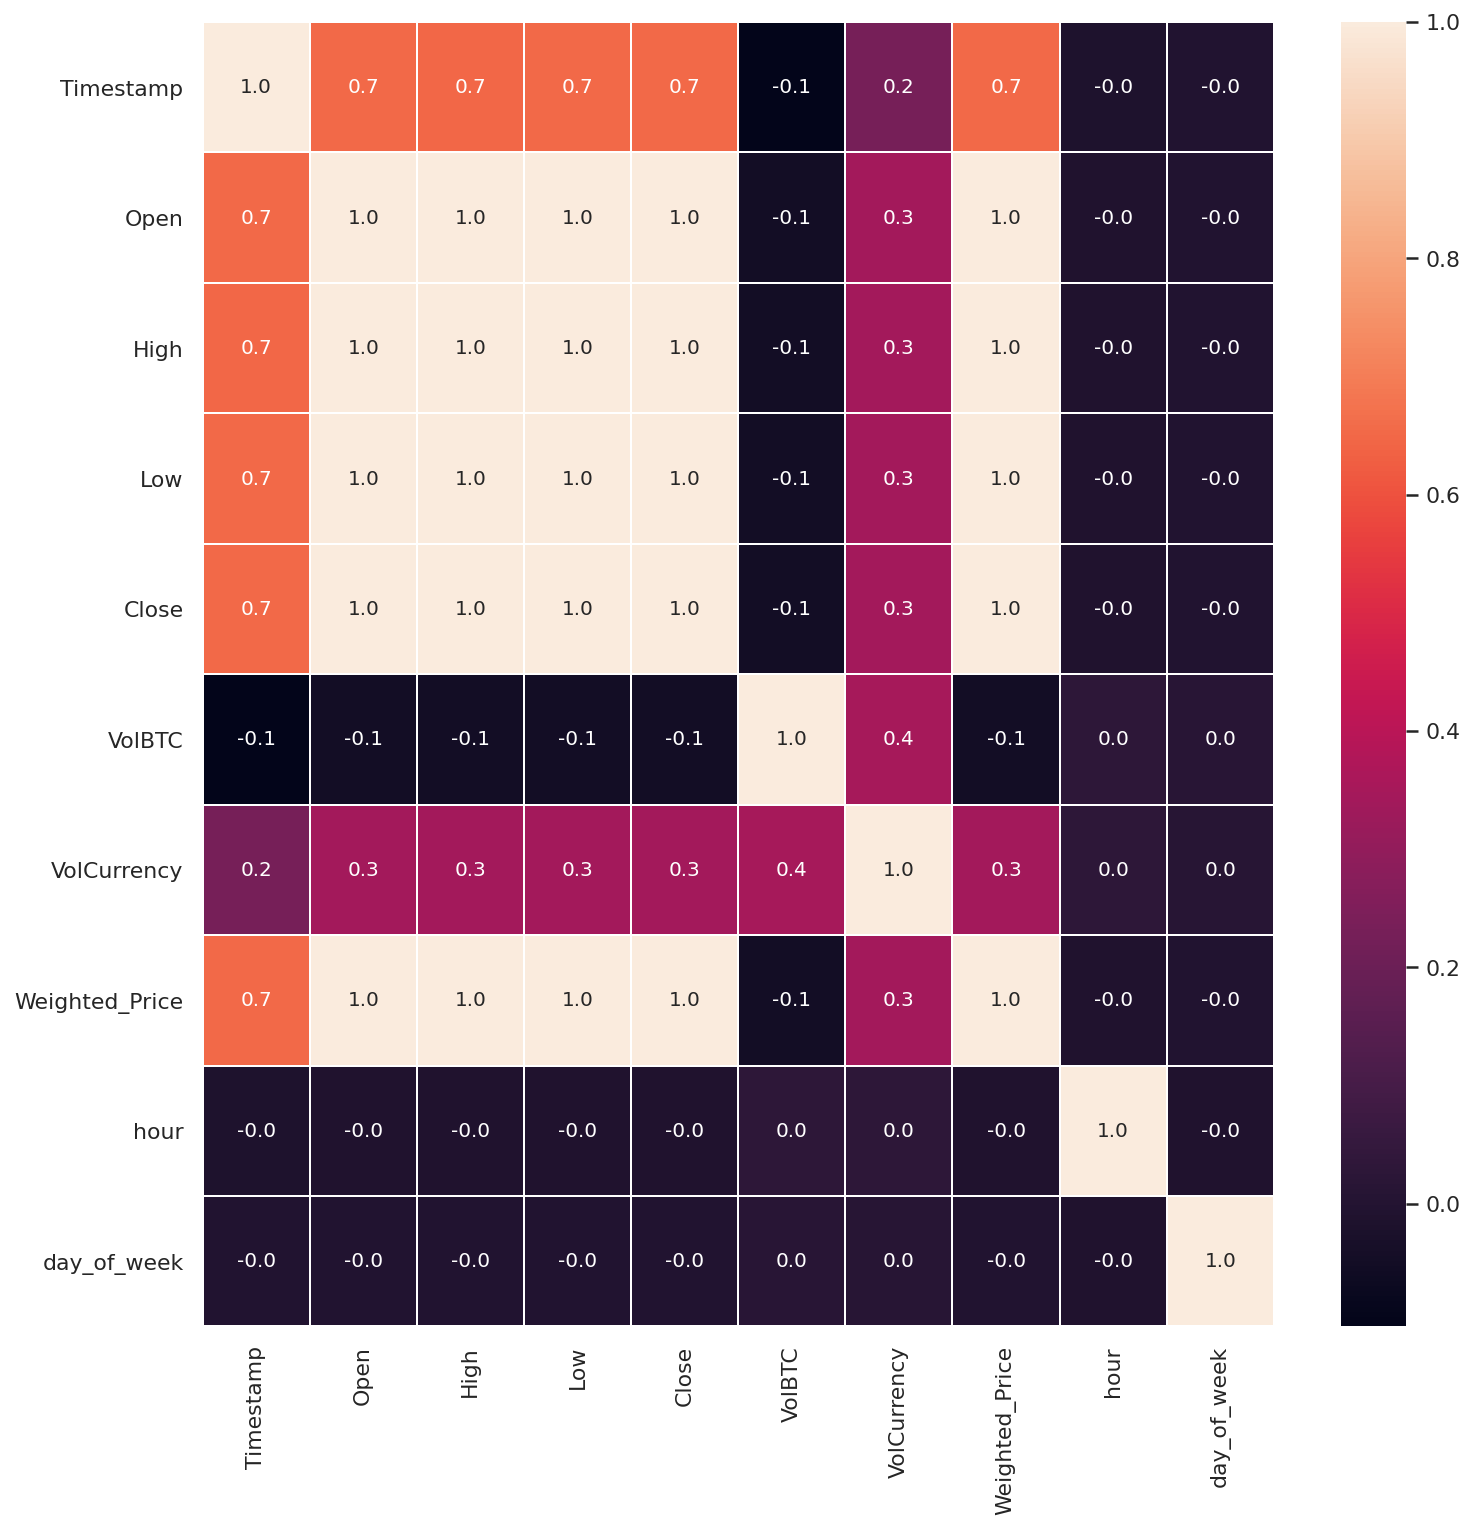

In [20]:
#Correlation plotting the heatmap using Seaborn
corr=pandas_converted.corr()
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.1f',ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='VolBTC', ylabel='VolCurrency'>

Text(0.5, 0, 'BTC Volume')

Text(0, 0.5, 'Currency Volume')

Text(0.5, 1.0, 'BTC-Currency Scatter Plot')

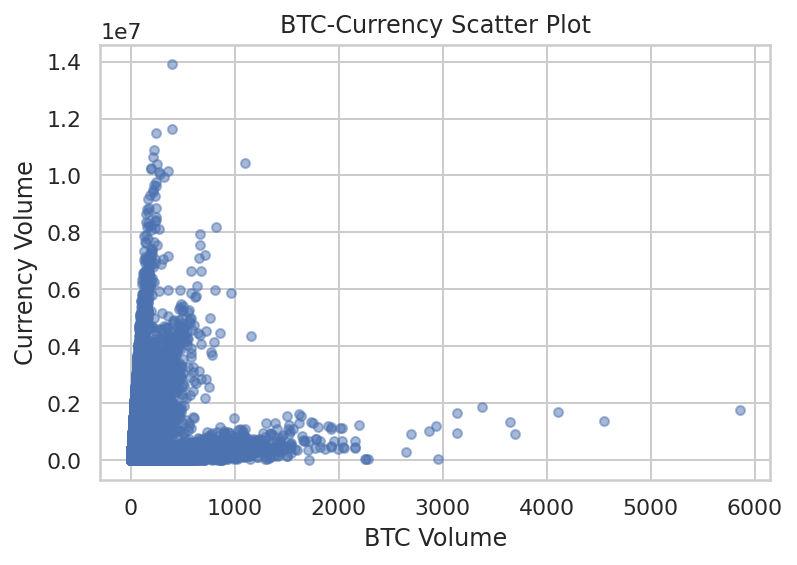

In [21]:
# Scatter Plot usage by Matplotlib
# x = open, y = close
pandas_converted.plot(kind='scatter', x='VolBTC', y='VolCurrency',alpha = 0.5)
plt.xlabel('BTC Volume')            
plt.ylabel('Currency Volume')
plt.title('BTC-Currency Scatter Plot') 
plt.show()

<Figure size 1152x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Line plot')

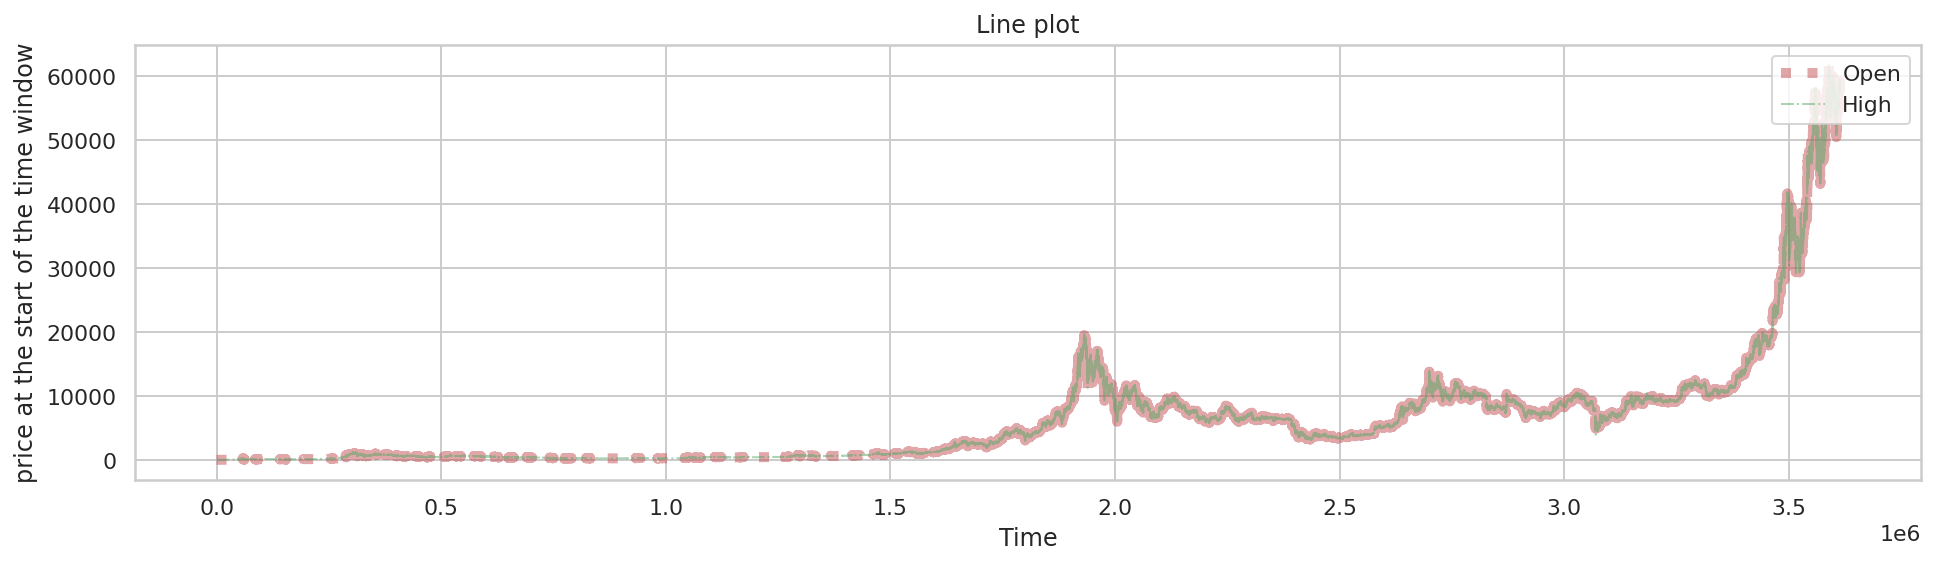

In [22]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind='line', color='r', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandas_converted.High.plot(color='g', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') #legend put label into plot
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Line plot')
plt.show()

<AxesSubplot:ylabel='Frequency'>

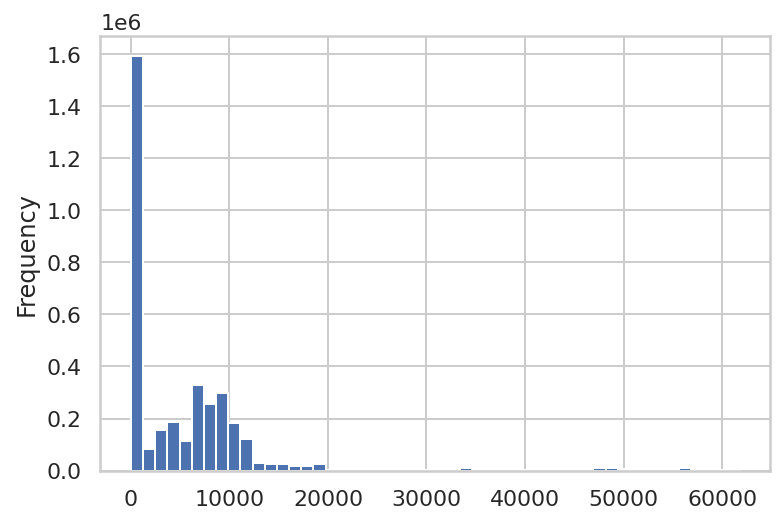

In [23]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind='hist', bins=50)

Text(0.5, 0, 'hour')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price by Hour')

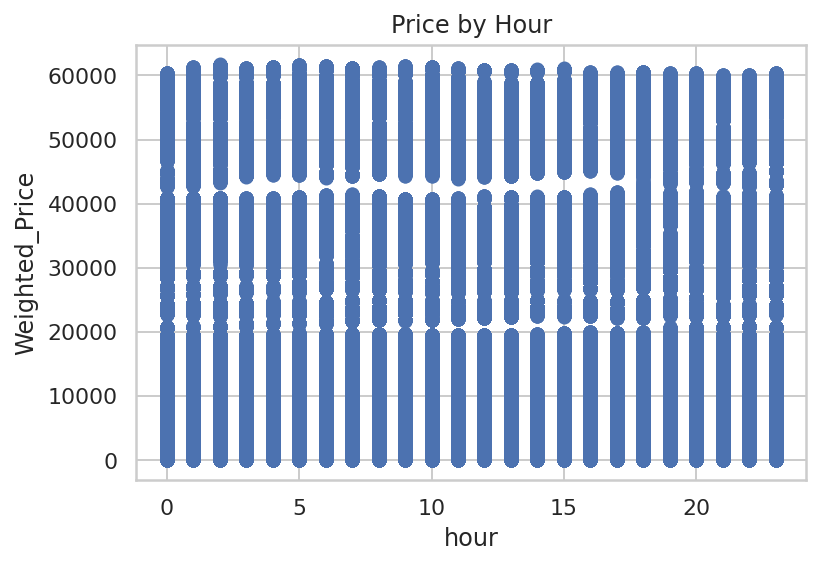

In [24]:
#Plot of Weighted_price per hour in scatter plot using Matplotlib
plt.plot(hour,weighted_price , 'bo')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('hour')            
plt.ylabel('Weighted_Price')
plt.title('Price by Hour') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price By Week')

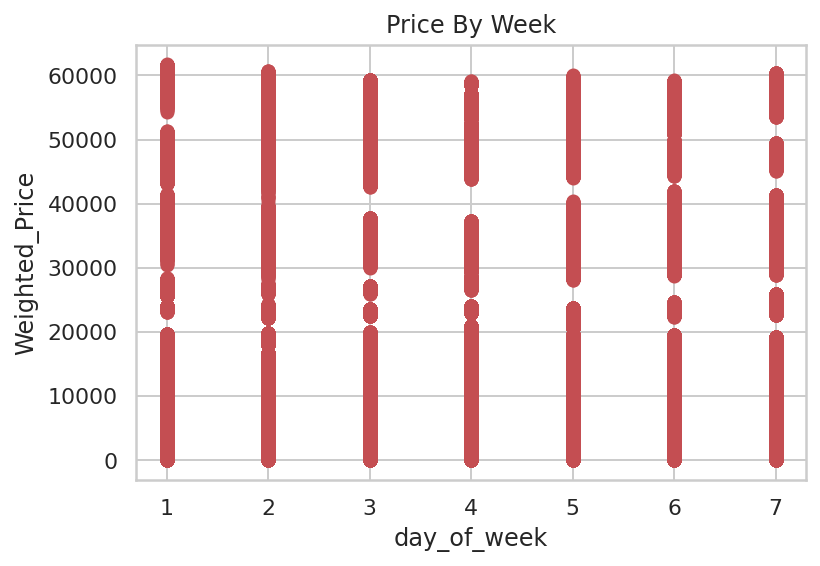

In [25]:
#Plot of Weighted_price per week in scatter plot using Matplotlib
plt.plot(date_of_week, weighted_price, 'ro')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('day_of_week')            
plt.ylabel('Weighted_Price')
plt.title('Price By Week') 
plt.show()


Text(0.5, 0, 'hour')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume by Hour of day')

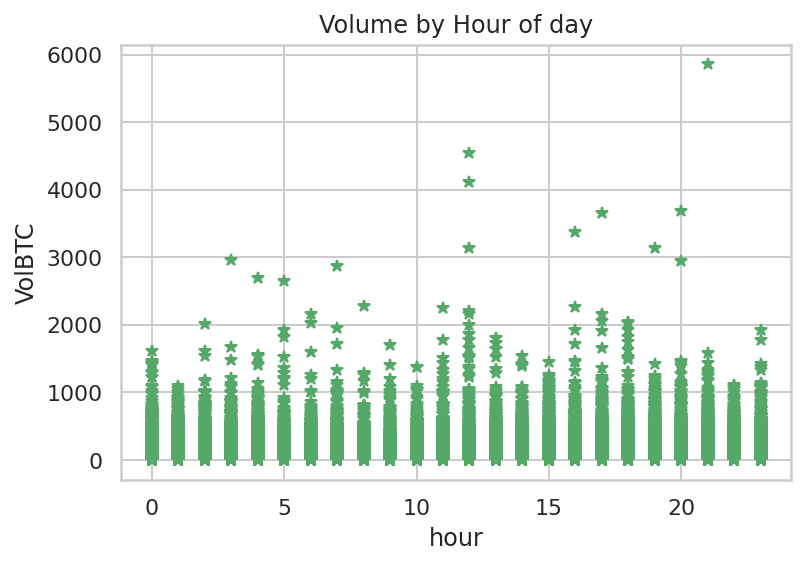

In [26]:
#Plot of VolBTC per hour change displayed in scatter plot using Matplotlib
plt.plot(hour, volume_BTC, 'g*')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('hour')            
plt.ylabel('VolBTC')
plt.title('Volume by Hour of day') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume By Week')

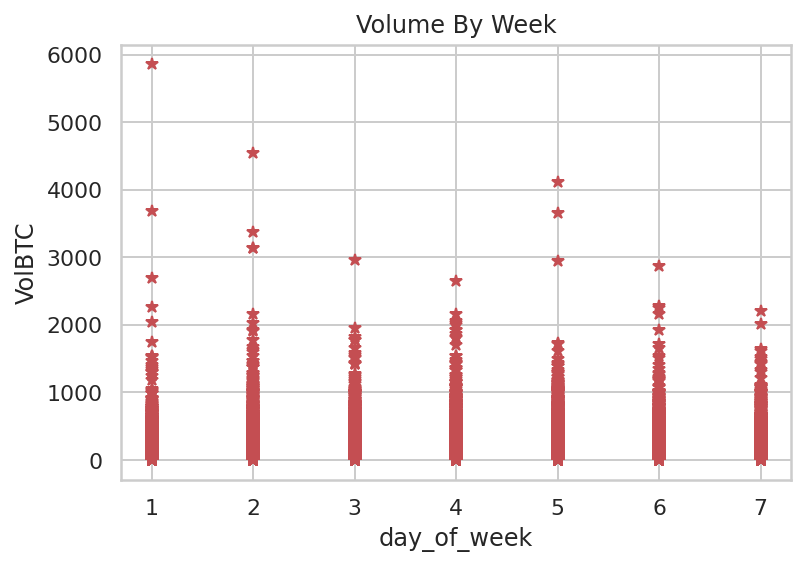

In [27]:
#Plot of VolBTC per day_of_Week change displayed in scatter plot using Matplotlib
plt.plot(date_of_week,volume_BTC , 'r*')
plt.xlabel('day_of_week')            
plt.ylabel('VolBTC')
plt.title('Volume By Week') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Weighted Price plotted yearly basis')

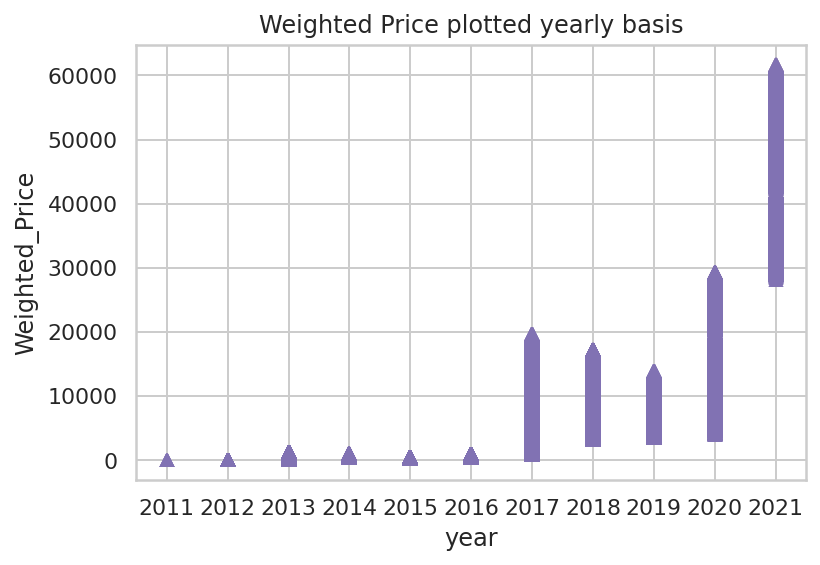

In [28]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,weighted_price , 'm^')
plt.xlabel('year')            
plt.ylabel('Weighted_Price')
plt.title('Weighted Price plotted yearly basis') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'volume_BTC')

Text(0.5, 1.0, 'volume_BTC plotted yearly basis')

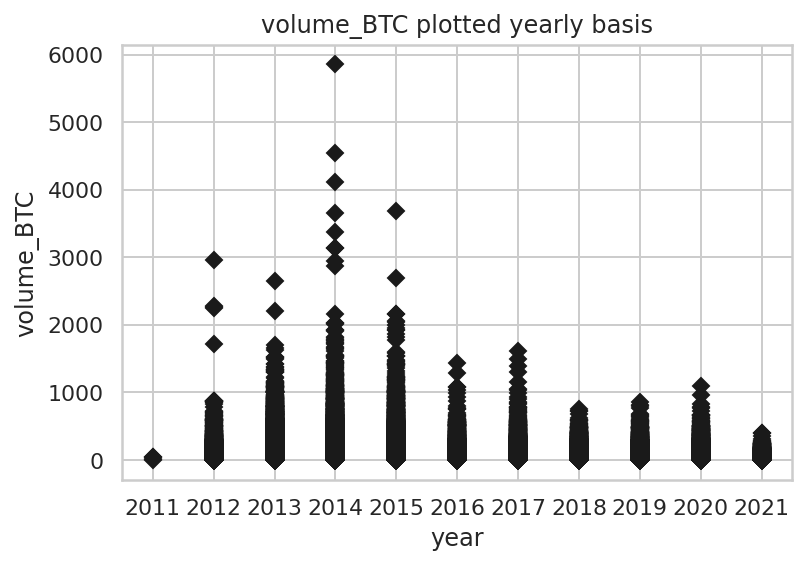

In [29]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,volume_BTC , 'kD')
plt.xlabel('year')            
plt.ylabel('volume_BTC')
plt.title('volume_BTC plotted yearly basis') 
plt.show()

# Feature Engineering/Extraction

In [30]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=['Open','High', 'VolBTC', 'VolCurrency','Weighted_Price'], outputCol="features")
assembled_df = assembler.transform(bitstampUSD)
assembled_df.show(10, truncate= False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                                        |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 13:22:00|[4.39,4.39,0.45558087,2.0000000193,4.39]        |
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 21:20:00|[4.39,4.39,48.0,210.72,4.39]                    |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 22:29:00|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 22:30:00|[4.58,4.58,9.0,41.22,4.58]                      |

In [31]:
# Initialize the `Min_Max_scaler`
Min_Max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# Fit the DataFrame to the scaler
scaled_df= Min_Max_scaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "scaled_features").show(10, truncate=False)
scaled_df.columns

+------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|features                                        |scaled_features                                                                                                |
+------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|[4.39,4.39,0.45558087,2.0000000193,4.39]        |[9.553145931914242E-6,9.550320720812882E-6,7.782582427582654E-5,1.4387793343672024E-7,9.560476483453811E-6]    |
|[4.39,4.39,48.0,210.72,4.39]                    |[9.553145931914242E-6,9.550320720812882E-6,0.008199728766573702,1.51589789206087E-5,9.560476483453811E-6]      |
|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|[1.1334240936169445E-5,1.2463977889874449E-5,0.006467928495112392,1.2328924278777876E-5,1.1770915333572205E-5] |
|[4.58,4.58,9.0,41.22,

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

# Building A Machine Learning Model With Spark ML

In [32]:
# Split the data into train,test and Validation sets
train_data, test_data = scaled_df.randomSplit([.7,.3], seed=rnd_seed)

In [33]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='scaled_features' , labelCol="Weighted_Price", predictionCol='Predicted_price', 
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [34]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [36]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 6.348396501944179|          4.39|
| 6.538287023302496|          4.58|
|6.9580450178840385|           5.0|
| 7.277860632803309|          5.32|
| 7.247877918904627|          5.29|
| 7.247877918904627|          5.29|
| 7.147935539242356|          5.19|
|  7.32132050395742|  5.3604618117|
| 7.729971200798147|   5.777027027|
|7.9574688145067585|           6.0|
+------------------+--------------+
only showing top 10 rows



In [37]:
# Select (predicted_price, Weighted_price label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.79811


Text(0.5, 1.0, 'Log Training Error vs. Iterations')

Text(0.5, 0, 'Log Training Error')

Text(0, 0.5, 'Iterations')

MAE: 2.964233752667313


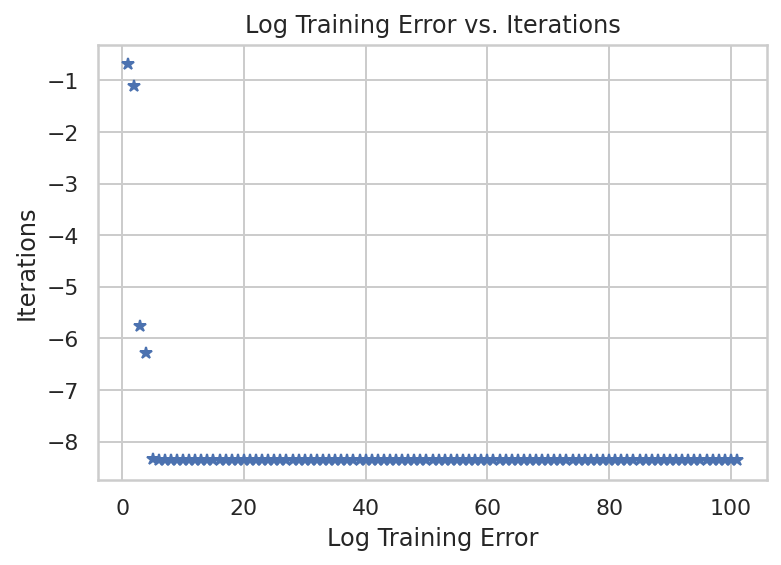

In [40]:
#Inspect and Model the metrics and Coefficient and Visualize the log of the training error as a function of iteration. 
#The scatter plot visualizes the logarithm of the training error for all 10 iterations.

iterations = list(range(1,linearModel.summary.totalIterations+2))
lossHistory = np.log(linearModel.summary.objectiveHistory)
plt.plot(iterations,lossHistory,'*')
plt.title('Log Training Error vs. Iterations')
plt.xlabel('Log Training Error')
plt.ylabel('Iterations')
# Intercept for the model
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

In [41]:
#Use this model for prediction on test data. Calculate Root Mean Square Error of our model.
predictionsTest = linearModel.transform(test_data)
predictionsTest.select("Predicted_price", "Weighted_Price").show(10)

rmse = evaluator.evaluate(predictionsTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 6.348396501944179|          4.39|
| 6.538287023302496|          4.58|
|6.9580450178840385|           5.0|
| 7.277860632803309|          5.32|
| 7.247877918904627|          5.29|
| 7.247877918904627|          5.29|
| 7.147935539242356|          5.19|
|  7.32132050395742|  5.3604618117|
| 7.729971200798147|   5.777027027|
|7.9574688145067585|           6.0|
+------------------+--------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 5.79811


/home/20MCB1015/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/20MCB1015/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

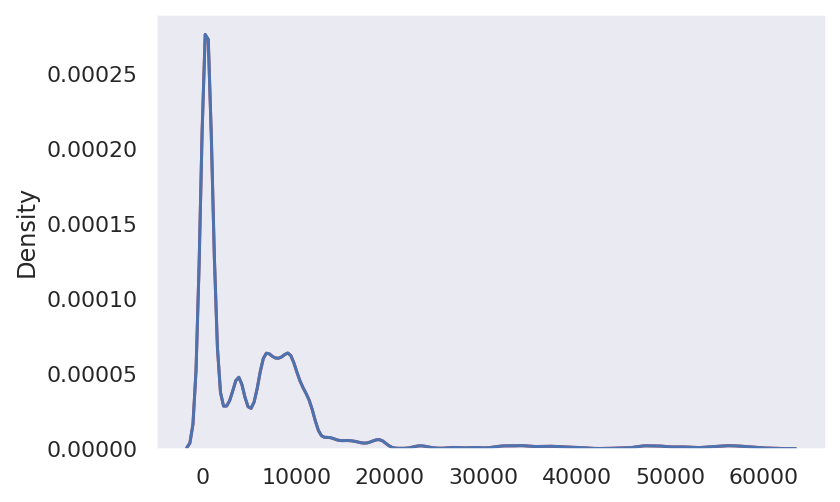

In [42]:
# Use the method "predict" to predict an output on the polynomial features,
# then use the function "DistributionPlot" to display the distribution of the Predicted_Price vs the Weighted_Price from the test data

pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Weighted_Price').toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()
sns.set_style("dark")
ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.distplot(_Y, hist=False, color="b", label="Fitted Values" , ax=ax1)

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'BitCoin Weighted Prediction')

Text(0.5, 0, 'Weighted_Price')

Text(0, 0.5, 'Predicted_price')

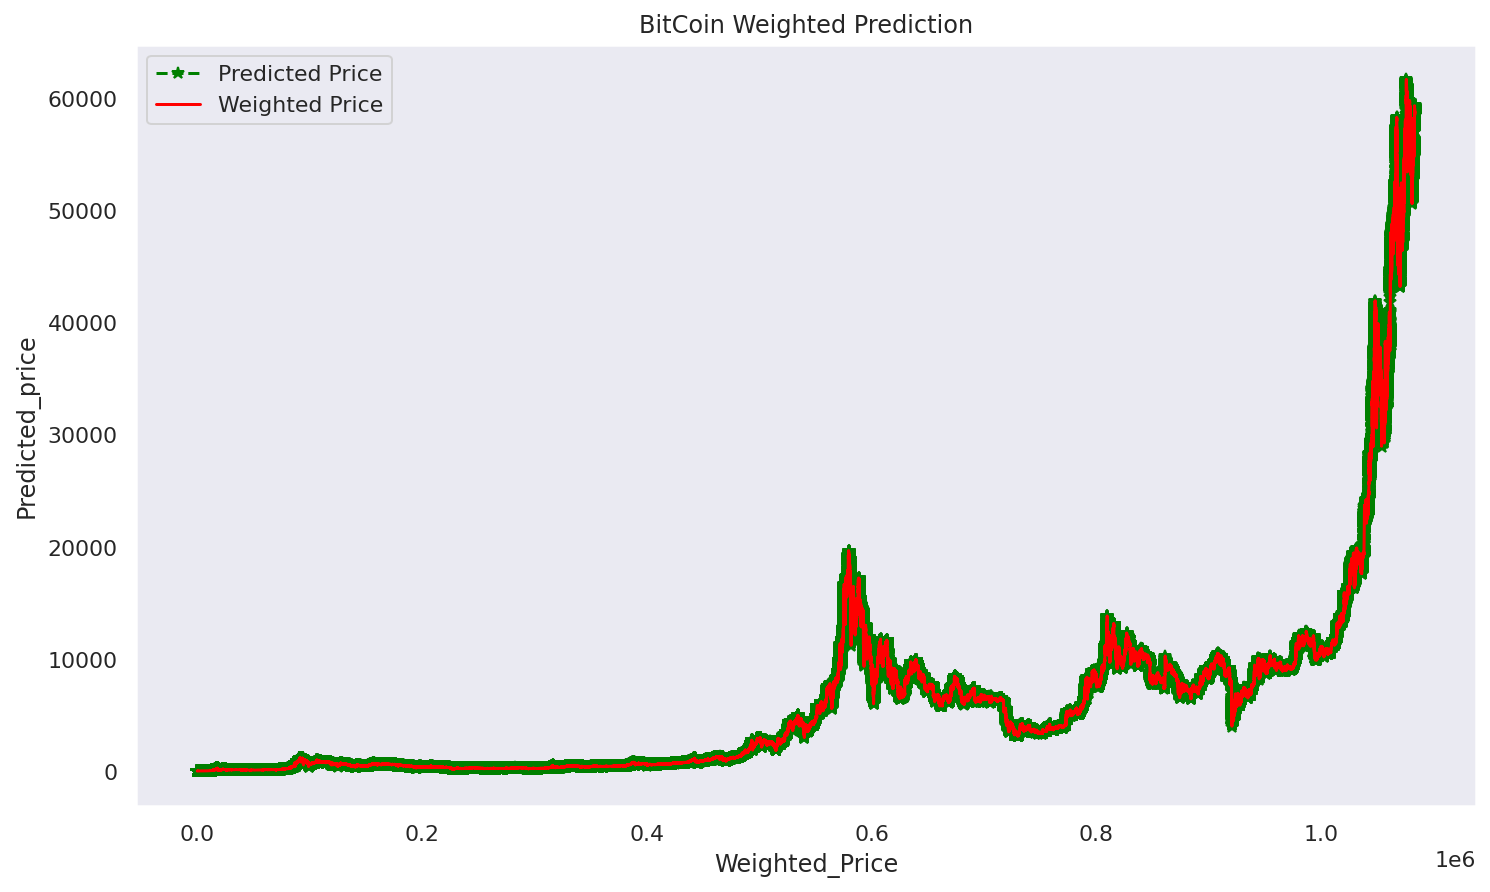

In [43]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('BitCoin Weighted Prediction')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()

# Model 2

In [103]:
from pyspark.ml.regression import GBTRegressor

In [116]:
gbt = GBTRegressor(featuresCol='scaled_features' , labelCol="Weighted_Price", predictionCol='Predicted_price', 
                               maxIter=1000)

In [117]:
gbtModel = lr.fit(train_data)

In [118]:
# Generate predictions
predictions = gbtModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(5)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 6.348396501944179|          4.39|
| 6.538287023302496|          4.58|
|6.9580450178840385|           5.0|
| 7.277860632803309|          5.32|
| 7.247877918904627|          5.29|
+------------------+--------------+
only showing top 5 rows



In [119]:
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.79811


<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'BitCoin Weighted Prediction')

Text(0.5, 0, 'Weighted_Price')

Text(0, 0.5, 'Predicted_price')

Exception ignored in: <function JavaWrapper.__del__ at 0x7fc646033310>
Traceback (most recent call last):
  File "/opt/spark/spark-3.1.1-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeRegressor' object has no attribute '_java_obj'


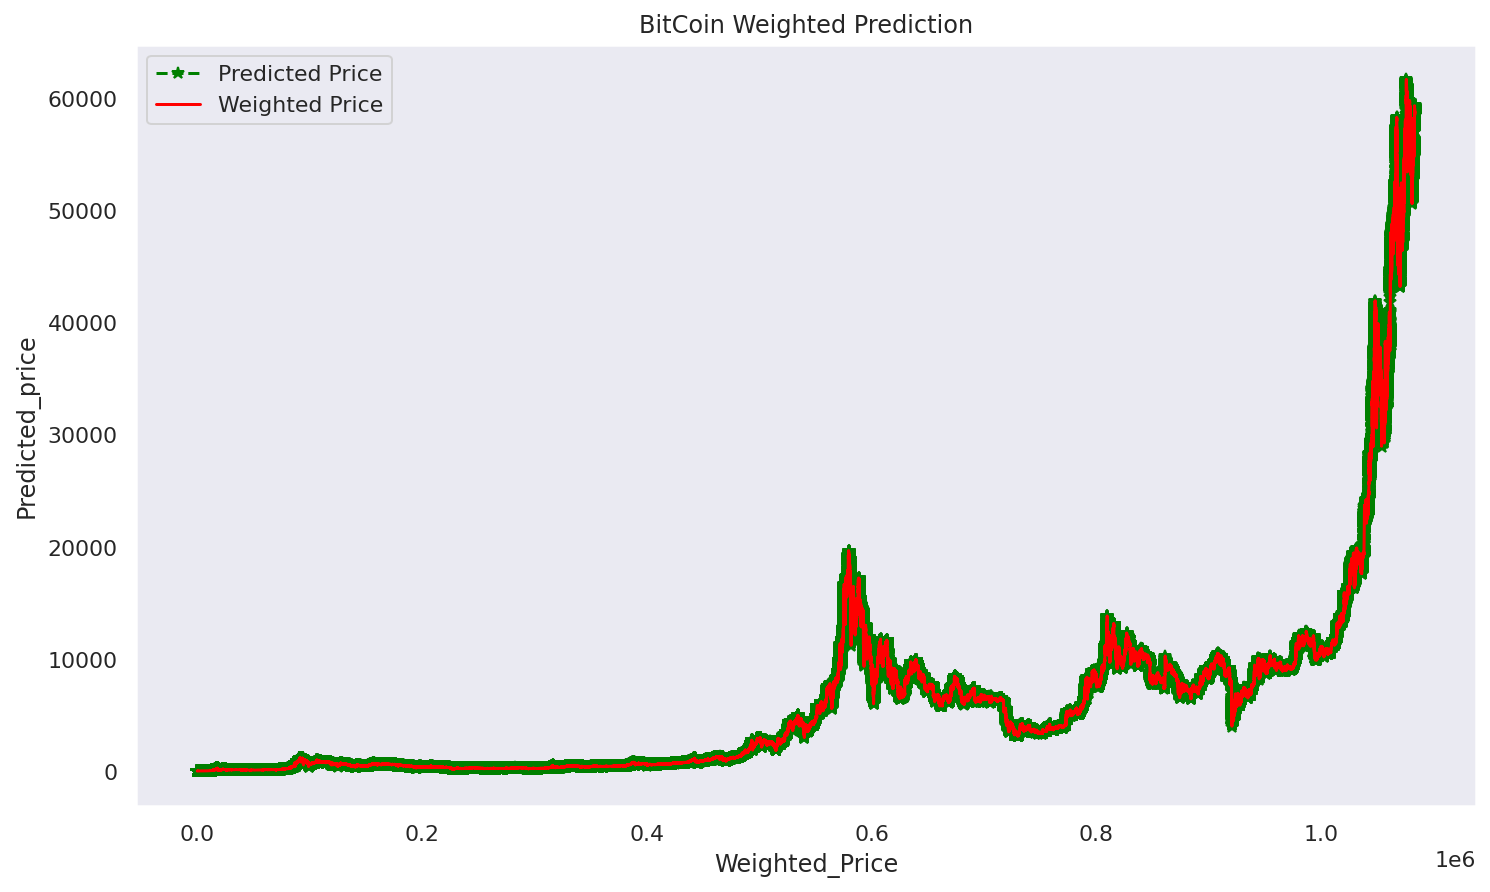

In [115]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('BitCoin Weighted Prediction')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()

In [120]:
sc.stop()

In [121]:
spark.stop()